In [7]:
import requests
from bs4 import BeautifulSoup as bs
from selenium import webdriver
import time
import pandas as pd

In [11]:
#need to install the chromedriver.exe in the Anaconda3/scripts folder or you will get a path error
driver = webdriver.Chrome()

#fetch url with selenium using chrome looping through to page 18, after that there are no school ratings
school_name_list = []
school_street_list = []
school_zip_list = []
school_city_list = []
school_rating_list = []
page_num = 1

while page_num < 19:
#setting url to get school ratings table that we will scrape.  Will iterate using page_num
    url = f"https://www.greatschools.org/search/search.page?gradeLevels%5B%5D=e&q=houston%20tx&sort=rating&view=table&page={page_num}"
    driver.get(url)
    
#using sleep to ensure page is fully loaded each loop before attempting to scrape    
    time.sleep(8)

#returning selenium html and then switching to beautiful soup
    innerHTML = driver.execute_script("return document.body.innerHTML")
    
    soup = bs(innerHTML,'lxml')
    
#limiting to 25 because the page is duplicating the html then hiding one set.  Was getting 50 out of 25 results

    school_name = soup.find_all('a', class_ ='name',limit=25)
    school_street_zip = soup.find_all('div', class_ ='address',limit=25)
    school_rating = soup.find_all('div', class_ ='circle-rating--small',limit=25)
    
#looping through the above to get text from each element and append to lists

    for name in school_name:
        name = name.text
        school_name_list.append(name)
        
    for street in school_street_zip:
        street = street.text
        school_street_list.append(street[:-20])
        
    for zipcode in school_street_zip:
        zipcode = zipcode.text
        school_zip_list.append(zipcode[-5:])
    
    for city in school_street_zip:
        city = city.text
        school_city_list.append(city[-18:-11])
        
    for rating in school_rating:
        rating = rating.text
        school_rating_list.append(rating[:-3])
    
    page_num += 1
#     #giving time for page to fully load before scraping
#     time.sleep(20)
#     #get info using find_elements_by_class looping through list created and pulling innerHTML

#     #School Name
    
#     school_name = driver.find_elements_by_class_name('name')
#     for name in school_name:
#         name = name.get_attribute('innerHTML')
#         school_name_list.append(name)

#     #School Street

#     school_street = driver.find_elements_by_class_name('address')
#     for street in school_street:
#         street = street.get_attribute('innerHTML')
#         school_street_list.append(street[:-20])

#     #School Zip
    
#     school_zip = driver.find_elements_by_class_name('address')
#     for zipcode in school_zip:
#         zipcode = zipcode.get_attribute('innerHTML')
#         school_zip_list.append(zipcode[-5:])

#     #School Rating
    
#     school_rating = driver.find_elements_by_class_name('circle-rating--small')
#     for rating in school_rating:
#         rating = rating.get_attribute('innerHTML')
#         school_rating_list.append(int(rating[:-44]))

#       page_num += 1
    


In [28]:
# print len to check if scrape worked properly
print(len(school_city_list))
#,school_street_list,school_zip_list,school_rating_list))

450


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000027DFD4DF320>]],
      dtype=object)

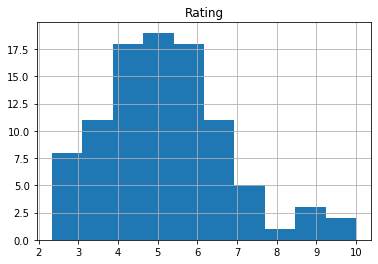

In [42]:
schools_dict = {'School':pd.Series(school_name_list),'Street':pd.Series(school_street_list),'Zip':pd.Series(school_zip_list),'City':pd.Series(school_city_list),'Rating':pd.Series(school_rating_list).astype(int)}
schools_df = pd.DataFrame(schools_dict)
#dropping last 6 rows because they did not have ratings
schools_df = schools_df[:-6]
#remove where city != Houston (ie school has Houston in name but not address)
schools_df = schools_df[schools_df.City =='Houston']
schools_df_plot = schools_df.groupby('Zip').mean()
schools_df_plot.hist()